In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import math
import time
import os
import sys

In [0]:
def nin_block(in_channels,out_channels,kernel_size,strides,padding):
    blk = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,strides,padding),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=1),
            nn.ReLU())
    return blk

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n1 = nin_block(1,out_channels=96, kernel_size=11, strides=4, padding=0)
        self.m1 = nn.MaxPool2d(3,stride=2)
        self.n2 = nin_block(96,out_channels=256, kernel_size=5, strides=1, padding=2)
        self.m2 = nn.MaxPool2d(3,stride=2)
        self.n3 = nin_block(256,out_channels=384, kernel_size=3, strides=1, padding=1)
        self.m3 = nn.MaxPool2d(3,stride=2)
        self.dropout1 = nn.Dropout2d(0.5)
        self.n4 = nin_block(384,out_channels=10, kernel_size=3, strides=1, padding=1)
        #Global Average Pooling can be achieved by AdaptiveMaxPool2d with output size = (1,1)
        self.avg1 = nn.AdaptiveMaxPool2d((1,1))
        self.flat = Flatten()
        
    def forward(self, x): 
        x = self.m1(self.n1(x))
        x = self.m2(self.n2(x))
        x = self.dropout1(self.m3(self.n3(x)))
        x = self.n4(x)
        x = self.avg1(x)
        x = self.flat(x) 
        return x

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [4]:
net = Net()
X = torch.rand(size=(1,1,224,224))
for layer in net.children():
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout2d output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [12]:
lr, num_epochs, batch_size, device = 0.1, 5, 128, "cuda:0"

#Xavier initialization of weights
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)


Net(
  (n1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (m1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (n2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (m2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (n3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (m3): MaxPool2d(kernel_size=3, strid

In [0]:
def load_data_fashion_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, transform=transformer, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transformer, download=True)
    num_workers = 0 if sys.platform.startswith('win32') else 4

    train_iter =torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)
    test_iter =torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter
batch_size =64
train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=224)

In [14]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 224, 224])

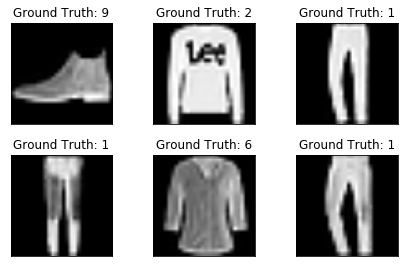

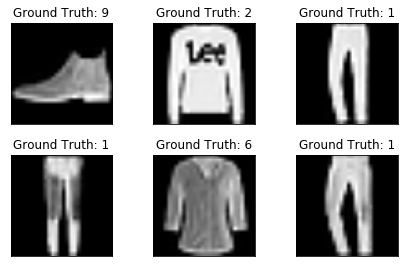

In [15]:

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
def train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr=None):
    """Train and evaluate a model with CPU or GPU."""
    print('training on', device)
    net.to(device)
    optimizer = optim.SGD(net.parameters(), lr=lr)
    for epoch in range(num_epochs):
        net.train() # Switch to training mode
        n, start = 0, time.time()
        train_l_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        train_acc_sum = torch.tensor([0.0], dtype=torch.float32, device=device)
        for X, y in train_iter:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                train_l_sum += loss.float()
                train_acc_sum += (torch.sum((torch.argmax(y_hat, dim=1) == y))).float()
                n += y.shape[0]

        test_acc = evaluate_accuracy(test_iter, net, device) 
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'\
            % (epoch + 1, train_l_sum/n, train_acc_sum/n, test_acc, time.time() - start))

In [0]:
def evaluate_accuracy(data_iter, net, device=torch.device('cpu')):
    """Evaluate accuracy of a model on the given data set."""
    net.eval()  # Switch to evaluation mode for Dropout, BatchNorm etc layers.
    acc_sum, n = torch.tensor([0], dtype=torch.float32, device=device), 0
    for X, y in data_iter:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(net(X), dim=1) == y))
            n += y.shape[0]
    return acc_sum.item()/n


In [21]:
criterion = nn.CrossEntropyLoss()

train_ch5(net, train_loader, test_loader, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0132, train acc 0.717, test acc 0.696, time 154.7 sec
epoch 2, loss 0.0113, train acc 0.753, test acc 0.764, time 154.6 sec
epoch 3, loss 0.0105, train acc 0.770, test acc 0.745, time 154.4 sec
epoch 4, loss 0.0101, train acc 0.778, test acc 0.753, time 154.7 sec
epoch 5, loss 0.0097, train acc 0.784, test acc 0.784, time 154.6 sec


In [0]:
train_loss=[0.0132,0.0113,0.0105,0.0101,0.0097]

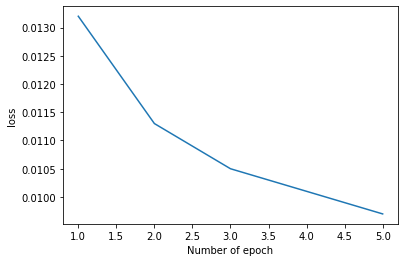

In [32]:
plt.plot([1,2,3,4,5],train_loss)
plt.xlabel("Number of epoch")
plt.ylabel("loss")
plt.show()

In [0]:
with torch.no_grad():
  net.to('cpu')
  output = net(example_data)

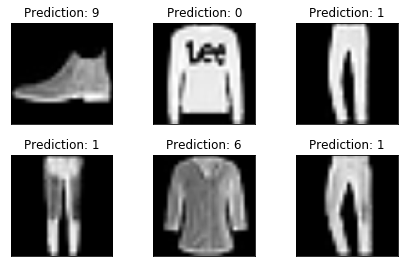

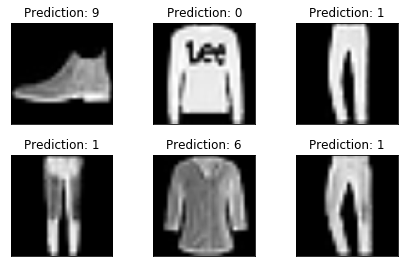

In [26]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig